In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
warnings.filterwarnings("ignore")
#
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
#
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
#
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, LSTM
import tensorflow as tf
from tensorflow import keras
#
start = time.time()
df = pd.read_csv('C:/Users/sick/Py/AUXILIARY/DF/2022/Feb/Ren_Pr_Sept21_Jan22.csv', sep=';', low_memory=False)
pd.set_option('display.max_columns', None)
df['Дата'] = pd.to_datetime(df['Дата'])
df['Время'] = pd.to_datetime(df['Время'])
df['Час'] = df.Время.dt.hour
df.Дата = df.Дата.dt.strftime('%Y-%d-%m')
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)
df.rename(columns={'Тип поста': 'Тип_поста', 'Тип источника': 'Тип_источника'}, inplace=True)
warnings.filterwarnings('ignore')
dfr = df
dfr_for_subs = dfr
dfr = dfr.drop_duplicates(subset=['Профиль места публикации', 'Тип_поста']) #DF для метрики "Подписчики места публикации"
dfr_for_subs = dfr_for_subs.drop_duplicates(subset=['Профиль', 'Тип_поста']) #DF для метрики "Подписчики"

# DF creation

In [169]:
data = df.query('Тональность == "Негативная"').groupby(['Дата', 'Час'], as_index=False) \
         .agg({'Час': ['unique', 'count'], 
               'Автор': 'nunique'}) \
                .rename(columns={'count': 'Упоминания',
                        'unique': 'Час', 
                        '': 'Дата',
                        'nunique' : 'unique_authors'}) 
data.columns = data.columns.droplevel()
data.Час = data.Час.astype(int)

#Серия по нейтралу
neutral = df.query('Тональность == "Нейтральная"').groupby(['Дата', 'Час'], as_index=False) \
         .agg({'Час': ['unique', 'count'], 
               'Автор': 'nunique'}) \
         .rename(columns={'count': 'Нейтрал',
               'unique': 'Час', 
               '': 'Дата',
               'nunique' : 'Нейтр_авторы'}) 
neutral.columns = neutral.columns.droplevel()
neutral.Час = neutral.Час.astype(int)

#Серия по позитиву
positive = df.query('Тональность == "Позитивная"').groupby(['Дата', 'Час'], as_index=False) \
         .agg({'Час': ['unique', 'count'], 
               'Автор': 'nunique'}) \
         .rename(columns={'count': 'Позитив',
               'unique': 'Час', 
               '': 'Дата',
               'nunique' : 'Поз_авторы'}) 
positive.columns = positive.columns.droplevel()
positive.Час = positive.Час.astype(int)

# Столбец "упоминания" - негатив

In [170]:
neutral = neutral.merge(positive, how = 'outer', left_on=['Дата','Час'], right_on=['Дата','Час'])
neutral = neutral.merge(data, how = 'outer', left_on=['Дата','Час'], right_on=['Дата','Час'])
data = neutral
data.fillna(0, inplace = True)
data.drop(['Нейтр_авторы','Поз_авторы'],axis=1,inplace=True)

In [171]:
#Пост-обработка
data = data.assign(GR_mentions = data['Упоминания'].pct_change())
data.GR_mentions = round(data.GR_mentions,2)
data = data.assign(GR_unique_authors = data['unique_authors'].pct_change())
data.fillna(0,inplace=True)
data.GR_Unique_authors = round(data.GR_unique_authors,2)
data.Час = data.Час.astype(int)

#Добавление дополнительных метрик
data['reactions_sum'] = df.query('Тональность == "Негативная"').groupby(['Дата', 'Час'], as_index=False) \
                          .agg({'Сумма всех реакций': 'sum'})['Сумма всех реакций']

data['reposts_of_mentions'] = df.query('Тональность == "Негативная"').groupby(['Дата', 'Час'], as_index=False) \
                    .agg({'Репосты': 'sum'})['Репосты']

data['comments_of_mentions'] = df.query('Тональность == "Негативная"').groupby(['Дата', 'Час'], as_index=False) \
                     .agg({'Комментарии': 'sum'})['Комментарии']

#Добавление дополнительных метрик

reposts = df.query('Тональность == "Негативная"').query('Тип_поста == ["Репост", "Дополненный репост"] ') \
        .groupby(['Дата', 'Час'], as_index=False).agg({'Тип_поста': 'count'})
reposts.rename({'Тип_поста': 'reposts'}, axis=1, inplace = True)

comments = df.query('Тональность == "Негативная"').query('Тип_поста == "Комментарий"') \
        .groupby(['Дата', 'Час'], as_index=False).agg({'Тип_поста': 'count'})
comments.rename({'Тип_поста': 'comments'}, axis=1, inplace = True)

news = df.query('Тип_источника == "СМИ"').groupby(['Дата', 'Час'], as_index=False).agg({'Тип_источника': 'count'})
news.rename({'Тип_источника': 'СМИ'},axis = 1, inplace = True)

data = data.merge(news, how = 'left', left_on=['Дата','Час'], right_on=['Дата','Час'])
data = data.merge(reposts, how = 'left', left_on=['Дата','Час'], right_on=['Дата','Час'])
data = data.merge(comments, how = 'left', left_on=['Дата','Час'], right_on=['Дата','Час'])
data.fillna(0, inplace=True)

# Including Reach to DF

In [172]:
dfr['Подписчики места публикации'] = np.where(dfr['Просмотры'] >= 0, 0, dfr['Подписчики места публикации'])
dfr_for_subs['Подписчики'] = np.where(dfr_for_subs['Просмотры'] >= 0, 0, dfr_for_subs['Подписчики'])
pd.set_option('display.colheader_justify', 'center')

reach_df = df.groupby(['Дата', 'Час'], as_index=False).agg({'Час': ['unique']}) \
                                                      .rename(columns={'unique': 'Час', 
                                                                       '': 'Дата'})
reach_df.columns = reach_df.columns.droplevel()
reach_df.Час = reach_df.Час.astype(int)

# posts etc.
subs = dfr_for_subs.query('Тип_поста != "Комментарий"').groupby(['Дата', 'Час'], as_index=False).agg({'Подписчики': 'sum'})
views = dfr.query('Тип_поста != "Комментарий"').groupby(['Дата', 'Час'], as_index=False).agg({'Просмотры': 'sum'})
subs_profile = dfr.query('Тип_поста != "Комментарий"').groupby(['Дата', 'Час'], as_index=False).agg({'Подписчики места публикации': 'sum'})

# comments
subs_c = dfr_for_subs.query('Тип_поста == "Комментарий"').groupby(['Дата', 'Час'], as_index=False).agg({'Подписчики': 'sum'})
views_c = dfr.query('Тип_поста == "Комментарий"').groupby(['Дата', 'Час'], as_index=False).agg({'Просмотры': 'sum'})
subs_profile_c = dfr.query('Тип_поста == "Комментарий"').groupby(['Дата', 'Час'], as_index=False).agg({'Подписчики места публикации': 'sum'})

reach_df = pd.merge(reach_df, subs,  on=['Дата', 'Час'], how='left')
reach_df = pd.merge(reach_df, views,  on=['Дата', 'Час'], how='left')
reach_df = pd.merge(reach_df, subs_profile,  on=['Дата', 'Час'], how='left')
reach_df.rename({'Подписчики': 'subs', 
                 'Подписчики места публикации': 'subs_p',
                 'Просмотры': 'views' }, axis=1, inplace=True)

reach_df = pd.merge(reach_df, subs_c,  on=['Дата', 'Час'], how='left')
reach_df = pd.merge(reach_df, views_c,  on=['Дата', 'Час'], how='left')
reach_df = pd.merge(reach_df, subs_profile_c,  on=['Дата', 'Час'], how='left')
reach_df.rename({'Подписчики': 'subs_c', 
                 'Подписчики места публикации': 'subs_p_c',
                 'Просмотры': 'views_c'}, axis=1, inplace=True)

reach_df.fillna(0, inplace=True)

reach_df = reach_df.assign(p_reach = (reach_df.subs + reach_df.subs_p)*0.05 + (reach_df.subs_c + reach_df.subs_p_c)*0.004 + (reach_df.views + reach_df.views_c)*1.1)

reach_df.drop(['subs','subs_p', 'subs_c', 'subs_p_c', 'views', 'views_c'],axis=1,inplace=True)
data = pd.merge(data, reach_df,  on=['Дата', 'Час'], how='left')
data['GR_unique_authors'] = np.where(data['GR_unique_authors'] > 100000,1, data['GR_unique_authors'])
data['GR_mentions'] = np.where(data['GR_mentions'] > 100000,1, data['GR_mentions'])
data.iloc[:,2:-2] = data.iloc[:,2:-2].astype(int)
data.rename(columns={'Упоминания': 'mentions', 'Дата': 'date', 'Час': 'hour'}, inplace=True)


# EXCEL EXPORT

In [173]:
for i in data.hour:
    if i < 10:
        data.hour = data.hour.replace(i,"0%s:0%s:0%s" % (i,0,0))
    else:
        data.hour = data.hour.replace(i,"%s:0%s:0%s" % (i,0,0))
    
# exporting xlsx file
excel_df = pd.DataFrame(data.groupby(['date', 'hour']).agg({'mentions':'sum',
                                    'unique_authors': 'sum',
                                    'GR_mentions': 'sum',
                                    'GR_unique_authors': 'sum',
                                    'reactions_sum': 'sum',
                                    'reposts': 'sum',
                                    'comments': 'sum',
                                    'p_reach': 'sum'}))

# excel_df.to_excel('C:/Users/shein/Else/Downloads/table.xlsx')

excel_df['p_reach_roll'] = excel_df.p_reach.rolling(13).sum()
excel_df.fillna(0)
data['p_reach_roll'] = data.p_reach.rolling(12).sum()
data['gr_mentions_roll'] = data.GR_mentions.rolling(4).mean().round(3)
data['gr_unique_roll'] = data.GR_unique_authors.rolling(4).mean().round(3)
data.fillna(0, inplace = True)
data.fillna(0, inplace = True)

# NORMALIZATION

In [174]:
data = data[['date', 'hour', 'Нейтрал', 'Позитив', 'unique_authors',
       'GR_mentions', 'GR_unique_authors', 'reactions_sum',
       'reposts_of_mentions', 'comments_of_mentions', 'СМИ', 'reposts',
       'comments', 'p_reach', 'p_reach_roll', 'gr_mentions_roll',
       'gr_unique_roll', 'mentions']]
p = PowerTransformer()
# data_normalized = pd.DataFrame(p.fit_transform(data_normal))
data_normalized = data
data_normalized.iloc[:,2:-1] = p.fit_transform(data_normalized.iloc[:,2:-1])
# data_normalized.columns = data_normal.columns
# data_normalized.hist(figsize=(10,8))
# plt.tight_layout(pad=1.0)
# # plt.show()
data_normalized = data_normalized.merge(data.mentions.to_frame(), left_index=True, right_index=True)
data_normalized.drop('mentions_x', axis=1, inplace=True)

# XGBOOST

In [175]:
split_date = '2021-12-23'
data_train = data_normalized.loc[data_normalized.date <= split_date]
data_test = data_normalized.loc[data_normalized.date > split_date]

X_train = data_train.iloc[:,2:-1]
y_train = data_train.iloc[:,[-1]]
y_train = y_train.iloc[:,0]

X_test = data_test.iloc[:,2:-1]
y_test = data_test.iloc[:,[-1]]
y_test = y_test.iloc[:,0]

# Кросс-валидация и обучение модели

Fitting 3 folds for each of 10 candidates, totalling 30 fits


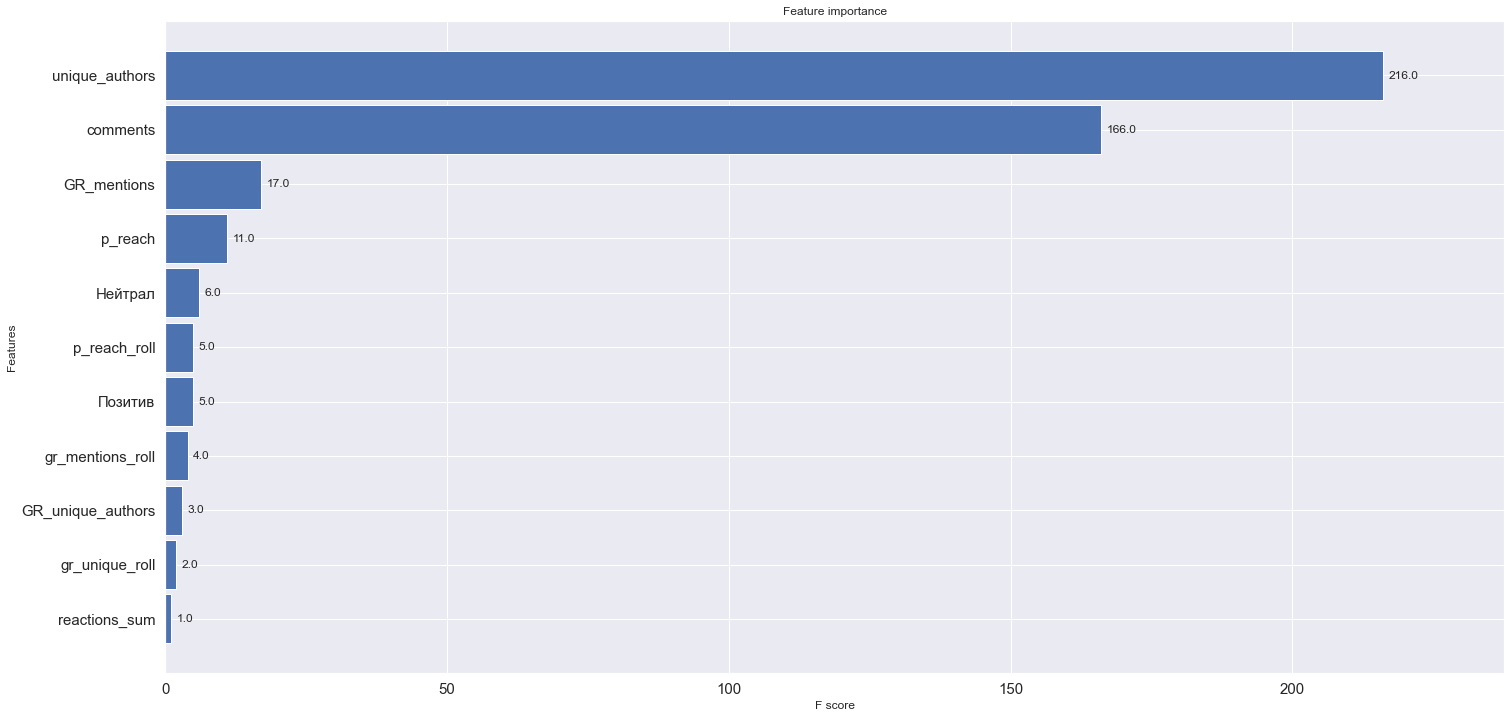

In [176]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

params = {  
            'eta': np.arange(0.1, 0.91, 0.15),
            'min_child_weight': np.arange(0.5, 4.51, 1).tolist(),
            'gamma': np.arange(1, 6.1, 1),
            'subsample': np.arange(0.1, 1.0, 0.19).tolist(),
            'colsample_bytree': np.arange(0.2, 1, 0.15).tolist()
         }

skf = StratifiedKFold(n_splits=3, shuffle = True)

grid = RandomizedSearchCV(xgb_model, 
                    param_distributions = params, 
                    n_jobs = 16, 
                    cv = skf.split(X_train, y_train),
                    refit = "accuracy_score", 
                    verbose=1)

grid.fit(X_train, y_train)

# Dictionary of best parameters
best_pars = grid.best_params_
best_model = grid.best_estimator_
data_test['XGBoost_prediction'] = best_model.predict(X_test)
_ = plot_importance(best_model, height=0.9)
_.tick_params(labelsize=15)

# Long-Short Term Memory Model (Specific type of Recurrent NN)

In [177]:
training_set = data_train
training_set.drop(['date', 'hour'], axis=1, inplace=True)
training_set = data_train
#
X_train = training_set.iloc[:,0:-1]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
#
y_train = data_train.iloc[:,-1]
y_train = np.reshape(y_train, (-1))

In [186]:
# model = load_model('C:/Users/shein/Py/2022/Feb/Youscan NN/Черновики/lstm_model_Youscan.h5')

model = Sequential()

model.add(LSTM(units = 80, activation = 'selu', input_shape = (15, 1), return_sequences = True))
model.add(Dropout(0.15))

model.add(Dense(units = 5, activation = 'elu'))
model.add(LSTM(units = 64, activation = 'elu', return_sequences = False))
model.add(Dropout(0.15))

model.add(Dense(units = 5, activation = 'elu'))
model.add(Dense(units = 1, activation = 'linear'))


r_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="min",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

e_s = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="min",
    baseline=None)

check_point = tf.keras.callbacks.ModelCheckpoint(
    filepath=('C:/Users/sick/Py/Projects/2022/March'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

opt = keras.optimizers.Adam(learning_rate=0.0001)

#  https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6

model.compile(loss='mean_squared_error', metrics = 'accuracy', optimizer = opt)

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, callbacks = [r_lr, check_point, e_s])

Epoch 1/100
76/76 - 3s - loss: 9.5845 - accuracy: 0.2598 - lr: 1.0000e-04 - 3s/epoch - 37ms/step
Epoch 2/100
76/76 - 1s - loss: 3.8120 - accuracy: 0.3472 - lr: 1.0000e-04 - 991ms/epoch - 13ms/step
Epoch 3/100
76/76 - 1s - loss: 3.0792 - accuracy: 0.3522 - lr: 1.0000e-04 - 987ms/epoch - 13ms/step
Epoch 4/100
76/76 - 1s - loss: 3.0325 - accuracy: 0.3497 - lr: 1.0000e-04 - 997ms/epoch - 13ms/step
Epoch 5/100
76/76 - 1s - loss: 3.0355 - accuracy: 0.3571 - lr: 1.0000e-04 - 961ms/epoch - 13ms/step
Epoch 6/100
76/76 - 1s - loss: 3.0390 - accuracy: 0.3649 - lr: 1.0000e-04 - 970ms/epoch - 13ms/step
Epoch 7/100
76/76 - 1s - loss: 2.9830 - accuracy: 0.3641 - lr: 1.0000e-05 - 1s/epoch - 13ms/step
Epoch 8/100
76/76 - 1s - loss: 2.9849 - accuracy: 0.3608 - lr: 1.0000e-05 - 980ms/epoch - 13ms/step
Epoch 9/100
76/76 - 1s - loss: 3.0154 - accuracy: 0.3695 - lr: 1.0000e-05 - 1s/epoch - 13ms/step
Epoch 10/100
76/76 - 1s - loss: 2.9414 - accuracy: 0.3670 - lr: 1.0000e-06 - 1s/epoch - 14ms/step
Epoch 11/10

In [187]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
yhat = model.predict(X_test, verbose=0)
yhat = np.reshape(yhat, (yhat.shape[0], yhat.shape[1]))
yhat = pd.DataFrame(yhat,index=range(len(yhat)))
yhat.rename(columns={0:'LSTM_prediction'}, inplace=True)
yhat.LSTM_prediction = yhat.LSTM_prediction.round(0).astype(int)
y_test = pd.DataFrame(y_test, columns = ['mentions_y'])
yhat['Test_sample'] = y_test.mentions_y.values

# XGBOOST VS LSTM MODEL

In [188]:
data_test['Month_day'] = data_test['date'].dt.strftime('%m-%d')
#
data_test = data_test.reset_index().drop(columns=['index'])
data_test = data_test.merge(yhat['LSTM_prediction'], left_on=data_test.index, right_index = True, how='left')
#
data_test1 = data_test[['date','hour','XGBoost_prediction', 'LSTM_prediction', 'mentions_y', 'Month_day']]
model.save('lstm_model_Youscan.h5') 
#
data_test1['LSTM_err'] = abs(((data_test1.LSTM_prediction / data_test1.mentions_y))*100-100).round(2)
data_test1['XG_err'] = abs(((data_test1.XGBoost_prediction / data_test1.mentions_y))*100-100).round(2)
# Создаем столбец день-месяц-час
data_test1['day_hour'] = data_test1['Month_day'].apply(lambda x: str(x[3:5])) + "/" + pd.to_datetime(data_test1.hour).dt.hour.astype(str)
data_test1.fillna(0,inplace=True)
# Замена inf на нули
data_test1.replace([np.inf, -np.inf], np.nan, inplace = True)

In [189]:
data_test1['day_hour'] = data_test1['Month_day'].apply(lambda x: str(x[3:5])) + "/" + pd.to_datetime(data_test1.hour).dt.hour.astype(str)

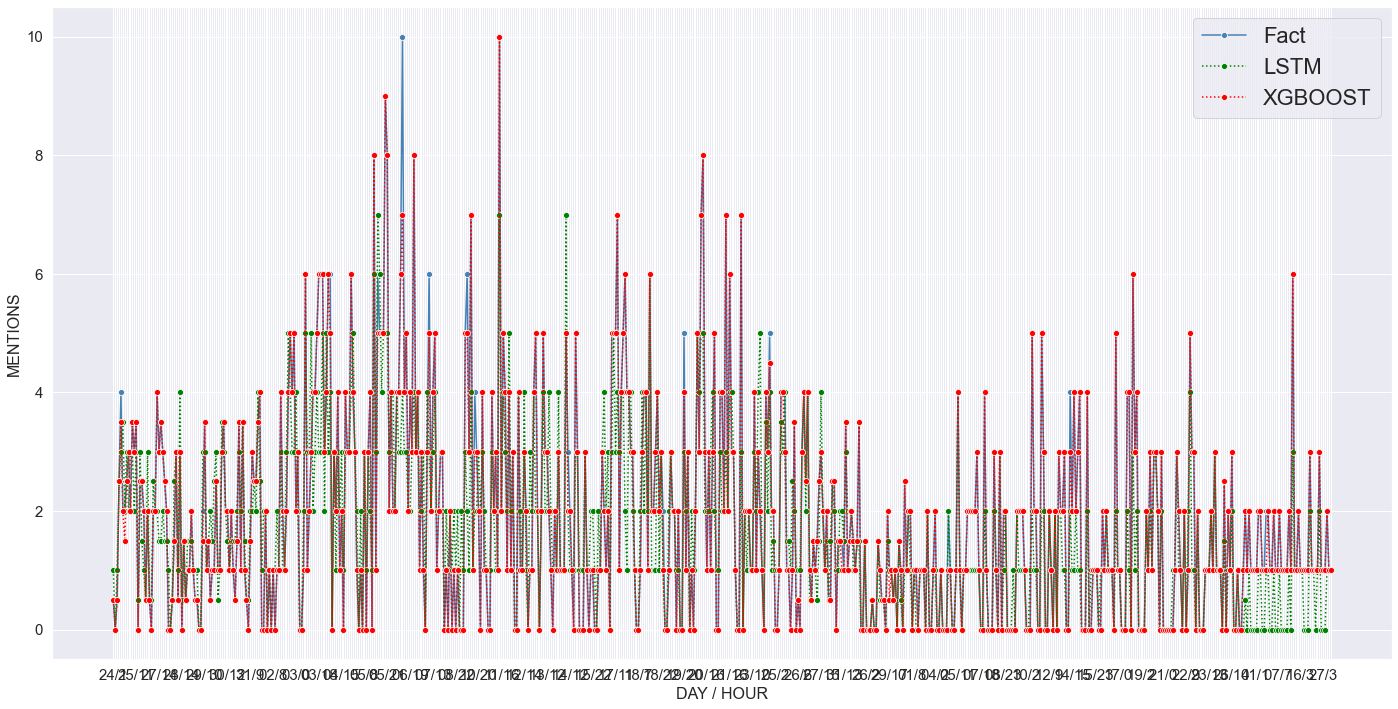

In [190]:
plt1 = sns.lineplot(x = data_test1.day_hour, y=data_test1.mentions_y, err_style=None, label='Fact', color = 'steelblue', marker='o')
plt2 = sns.lineplot(x = data_test1.day_hour, y=data_test1.LSTM_prediction, err_style=None, color = 'green', label='LSTM', linestyle='dotted', marker='o')
plt3 = sns.lineplot(x = data_test1.day_hour, y=data_test1.XGBoost_prediction, err_style=None, color = 'red', label='XGBOOST', marker='o', linestyle='dotted')


plt1.legend(fontsize=22)
plt1.set_ylabel('MENTIONS',size=16)
plt1.set_xlabel('DAY / HOUR',size=16)
plt1.tick_params(labelsize=15)

for ind, label in enumerate(plt1.get_xticklabels()):
    if ind % 12 == 0:  # every 4th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
sns.set(rc = {'figure.figsize':(25,12)})
plt.show()

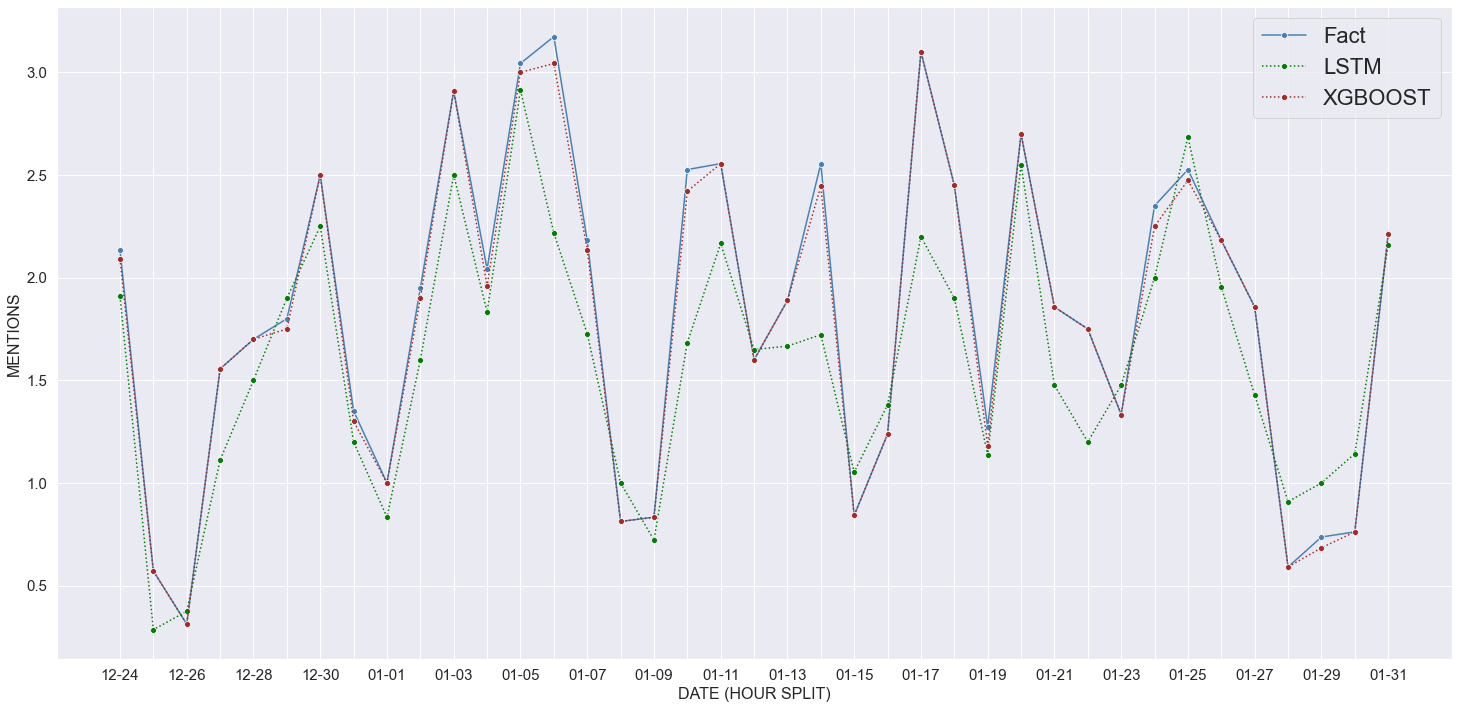

In [191]:
plt4 = sns.lineplot(x = data_test1.Month_day, y=data_test1.mentions_y, err_style=None, label='Fact', color = 'steelblue', marker='o')
plt5 = sns.lineplot(x = data_test1.Month_day, y=data_test1.LSTM_prediction, err_style=None, color = 'green', label='LSTM', linestyle='dotted', marker='o')
plt6 = sns.lineplot(x = data_test1.Month_day, y=data_test1.XGBoost_prediction, err_style=None, color = 'brown', label='XGBOOST', linestyle='dotted', marker='o')

plt4.legend(fontsize=22)
plt4.set_ylabel('MENTIONS',size=16)
plt4.set_xlabel('DATE (HOUR SPLIT)',size=16)
plt4.tick_params(labelsize=15)

for ind, label in enumerate(plt4.get_xticklabels()):
    if ind % 2 == 0:  # every 20th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
sns.set(rc = {'figure.figsize':(24,12)})        
plt.show()

In [192]:
end = time.time()
print('SCRIPT WAS EXECUTED IN ' + str(end-start) + ' seconds')

SCRIPT WAS EXECUTED IN 262.69177198410034 seconds


In [193]:
print('XGBOOST Accuracy_rate = ' + str(100-(data_test1.XG_err.mean())))
print('LSTM Accuracy_rate = ' + str(100-(data_test1.LSTM_err.mean())))

XGBOOST Accuracy_rate = 99.17596649484535
LSTM Accuracy_rate = 69.36233893557423


# XGBoost

In [ ]:
# data_test1.XG_err.hist()

# LSTM

In [ ]:
# data_test1.LSTM_err.hist()